# Correlation facility emitting pollutants and PM25/AQI levels

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import scipy as sc

plt.style.use('fivethirtyeight') # Use plt.style.available to see more styles
sns.set()
sns.set_context("talk")
%matplotlib inline

We will be using data from gas emitter data. We will link this to the AQI and PM2.5 levels.

The grannularity of the data is by county. The time cxonsidered is 2020, when the data has been collected.

# Data Extraction from gas emitter types

## Importing data

We are using: ```./raw/data/us_greenhouse_gas_emission_direct_emitter_gas_type.csv```

In [70]:
facilities_df = pd.read_csv('./raw/data/us_greenhouse_gas_emission_direct_emitter_gas_type.csv')

## Feature selection

In [71]:
columns_to_keep = [
    'V_GHG_EMITTER_GAS.FACILITY_ID',
    'V_GHG_EMITTER_GAS.GAS_CODE',
    'V_GHG_EMITTER_GAS.CO2E_EMISSION',
    'V_GHG_EMITTER_GAS.COUNTY_FIPS'
    ]
facilities_df = facilities_df.loc[:,columns_to_keep]
facilities_df.head(5)
facilities_df.shape

(219928, 4)

In [72]:
facilities_df['V_GHG_EMITTER_GAS.GAS_CODE'].value_counts()
# 'V_GHG_EMITTER_GAS.GAS_NAME' doesn't provide additionnal classes and explanations


CH4           77410
CO2           69076
N2O           62494
BIOCO2         6825
SF6            1419
HFC             636
PFC             634
Other_Full      472
NF3             444
Very_Short      251
HFE             201
Other            66
Name: V_GHG_EMITTER_GAS.GAS_CODE, dtype: int64

In [73]:
def get_metrics_for_1_gas(facilities, gas_code: str):
    facilities_gas = facilities[facilities['V_GHG_EMITTER_GAS.GAS_CODE'] == gas_code]

    def get_metrics(x):
        return (x.mean(), x.max(), len(x))

    facilities_by_county = facilities_gas.groupby('V_GHG_EMITTER_GAS.COUNTY_FIPS').agg(get_metrics)

    facilities_by_county[f'{gas_code}_mean'] = facilities_by_county['V_GHG_EMITTER_GAS.CO2E_EMISSION'].apply(lambda x: x[0])
    facilities_by_county[f'{gas_code}_max'] = facilities_by_county['V_GHG_EMITTER_GAS.CO2E_EMISSION'].apply(lambda x: x[1])
    facilities_by_county[f'{gas_code}_count'] = facilities_by_county['V_GHG_EMITTER_GAS.CO2E_EMISSION'].apply(lambda x: x[2])
    facilities_by_county = facilities_by_county.drop('V_GHG_EMITTER_GAS.CO2E_EMISSION', axis=1)
    facilities_by_county = facilities_by_county.drop('V_GHG_EMITTER_GAS.FACILITY_ID', axis=1)

    return facilities_by_county
    # size = facilities_gas.shape[0]
    # trouver moyen de prendre max, count, mean depuis le co2eq

def join_all_metrics(facilities):
    gas_types = facilities['V_GHG_EMITTER_GAS.GAS_CODE'].unique()
    print(gas_types)

    facilities_metrics = [get_metrics_for_1_gas(facilities, gas_code) for gas_code in gas_types]
    
    facilities = facilities_metrics[0].copy()
    for i in range(1,len(facilities_metrics)):
        facilities = facilities.join(facilities_metrics[i], on='V_GHG_EMITTER_GAS.COUNTY_FIPS', how='left')

    return facilities

# PLOT HEATMAP OF NAN
# Source: https://gist.github.com/NadimKawwa/98e42c26401db0dffde95fe4ddbea67e

def plot_nan_heatmap(df):
    #set figure size
    # plt.figure(figsize=(10,10))
    plt.figure()

    #generate heatmap
    sns.heatmap(df.isnull(), cbar=False)

    #labels and titles
    plt.title(f"NaN heatmap")
    #plt.yticks(np.arange(0, df.shape[0], 500))
    plt.xlabel("Column Index/Feature Space")
    plt.ylabel("Row Index/Observations")

    plt.show()


In [74]:
# with_metrics_ch4 = get_metrics_for_1_gas(facilities=facilities_df, gas_code='CH4')
# print(with_metrics_ch4.head(10))

fac = join_all_metrics(facilities=facilities_df)
print(fac)

['BIOCO2' 'CH4' 'N2O' 'CO2' 'SF6' 'Other_Full' 'PFC' 'HFC' 'Very_Short'
 'HFE' 'NF3' 'Other']


/usr/local/lib/python3.9/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


                                BIOCO2_mean  BIOCO2_max  BIOCO2_count  \
V_GHG_EMITTER_GAS.COUNTY_FIPS                                           
1001.0                         1.596640e+06   1683572.3            10   
1015.0                         4.100000e+00         4.1             1   
1023.0                         1.013726e+06   1126386.1            10   
1025.0                         7.011927e+05    749337.7            10   
1043.0                         2.343150e+03      4562.5             8   
...                                     ...         ...           ...   
56003.0                        2.041750e+03      4075.0             2   
56005.0                        1.205660e+03      3148.1             5   
72013.0                        1.598667e+02       230.2             3   
72053.0                        3.759850e+03      5018.8             4   
72137.0                        5.591467e+03      6707.8             3   

                                   CH4_mean     CH

## Data cleaning

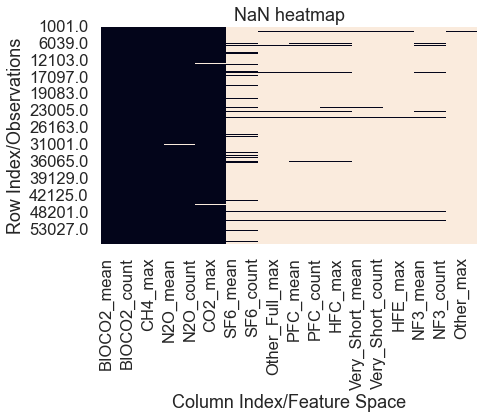

In [75]:
plot_nan_heatmap(fac)

To continue the cleaning, we will replace NaN columns by zeros. It makes sense as the companies not measuring specific types of gas emitted by the industry do this as they don't use those chemicals. For instance, a plant not using any product leading to PFC pollution doesn't need to track their emission related to this, as it would be 0.

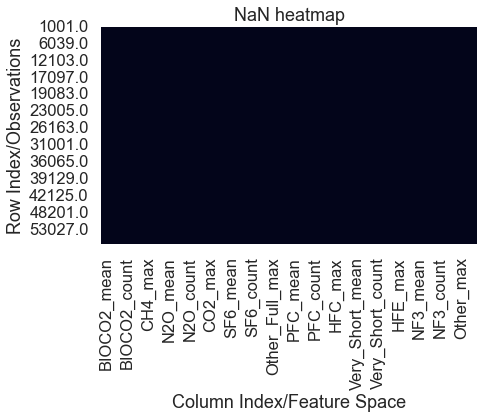

(746, 36)
Index(['BIOCO2_mean', 'BIOCO2_max', 'BIOCO2_count', 'CH4_mean', 'CH4_max',
       'CH4_count', 'N2O_mean', 'N2O_max', 'N2O_count', 'CO2_mean', 'CO2_max',
       'CO2_count', 'SF6_mean', 'SF6_max', 'SF6_count', 'Other_Full_mean',
       'Other_Full_max', 'Other_Full_count', 'PFC_mean', 'PFC_max',
       'PFC_count', 'HFC_mean', 'HFC_max', 'HFC_count', 'Very_Short_mean',
       'Very_Short_max', 'Very_Short_count', 'HFE_mean', 'HFE_max',
       'HFE_count', 'NF3_mean', 'NF3_max', 'NF3_count', 'Other_mean',
       'Other_max', 'Other_count'],
      dtype='object')
V_GHG_EMITTER_GAS.COUNTY_FIPS


In [76]:
fac = fac.fillna(0)
plot_nan_heatmap(fac)
print(fac.shape)
print(fac.columns)
print(fac.index.name)

# Data Extraction from pm25 and AQI level, county-wise

To compare the industry activity to PM2.5 levels, we use WHO's data on daily PM2.5 levels. This dataset gives all the concentrations in PM2.5 over the country from 2001 to 2016.

There is one issue though, as these data relates to 2016 data. We will try to match them. This can make sense, as industry and factory take a long amount of time to become operational and stay like this for a long time.

The source of the data is from: https://data.cdc.gov/Environmental-Health-Toxicology/Daily-PM2-5-Concentrations-All-County-2001-2016/7vdq-ztk9


## Importing Data

In [105]:
daily_pm25_concentrations = pd.read_csv('./raw/data/Daily_PM2.5_Concentrations_All_County__2001-2016.csv')
print(daily_pm25_concentrations.columns)
display(daily_pm25_concentrations.head(5))

Index(['year', 'date', 'statefips', 'countyfips', 'PM25_max_pred',
       'PM25_med_pred', 'PM25_mean_pred', 'PM25_pop_pred'],
      dtype='object')


,year,date,statefips,countyfips,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred
0,2001,01JAN2001,1,1,10.664367,10.264546,10.137631,10.188703
1,2001,01JAN2001,1,3,9.803209,8.739505,8.743748,8.811486
2,2001,01JAN2001,1,5,12.087599,11.809159,11.812775,11.802062
3,2001,01JAN2001,1,7,8.579425,8.435394,8.458118,8.448871
4,2001,01JAN2001,1,9,14.399446,13.577741,13.300528,13.231461


In [106]:
display(daily_pm25_concentrations.describe())

,year,statefips,countyfips,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred
count,1.816900e+07,1.816900e+07,1.816900e+07,1.816900e+07,1.816900e+07,1.816900e+07,1.816900e+07
mean,2.008501e+03,3.057510e+01,1.034374e+02,1.004194e+01,9.623689e+00,9.609705e+00,9.615355e+00
std,4.609846e+00,1.496420e+01,1.080642e+02,5.472293e+00,5.186734e+00,5.172078e+00,5.173289e+00
min,2.001000e+03,1.000000e+00,1.000000e+00,6.982100e-02,6.982100e-02,6.982100e-02,6.982100e-02
25%,2.004750e+03,1.900000e+01,3.500000e+01,6.319216e+00,6.071293e+00,6.063907e+00,6.068806e+00
50%,2.008500e+03,2.900000e+01,7.900000e+01,8.826722e+00,8.485531e+00,8.475155e+00,8.480602e+00
75%,2.012250e+03,4.600000e+01,1.330000e+02,1.239479e+01,1.189990e+01,1.188481e+01,1.189112e+01
max,2.016000e+03,5.600000e+01,8.400000e+02,4.915291e+02,3.352757e+02,3.852261e+02,3.826642e+02


## Feature Engineering and Selection

### Adding readable County Fips

The national county fips differs from the data we have here. We need to concatenate statefips and countyfips (here related to the state fips) to get the national fips as in the greenhouse gas emissions direct polluters datasets.

In [107]:
print(daily_pm25_concentrations['statefips'].dtype, daily_pm25_concentrations['countyfips'].dtype)

int64 int64


In [108]:
def get_national_county_fips(statefips: int, countyfips: int):
    state = str(statefips)
    county = str(countyfips)
    if len(state) < 2:
        nb_zeros_state = 2 - len(state)
        state = '0' * nb_zeros_state + state
    if len(county) < 3:
        nb_zeros_county = 3 - len(county)
        county = '0' * nb_zeros_county + county
    return state + county

# Quick check of the function's vailidity
print(get_national_county_fips(1, 12))

01012


In [109]:
daily_pm25_concentrations['COUNTY_FIPS'] = list(map(get_national_county_fips, daily_pm25_concentrations['statefips'], daily_pm25_concentrations['countyfips']))
display(daily_pm25_concentrations.head(10))

,year,date,statefips,countyfips,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred,COUNTY_FIPS
0,2001,01JAN2001,1,1,10.664367,10.264546,10.137631,10.188703,01001
1,2001,01JAN2001,1,3,9.803209,8.739505,8.743748,8.811486,01003
2,2001,01JAN2001,1,5,12.087599,11.809159,11.812775,11.802062,01005
3,2001,01JAN2001,1,7,8.579425,8.435394,8.458118,8.448871,01007
4,2001,01JAN2001,1,9,14.399446,13.577741,13.300528,13.231461,01009
5,2001,01JAN2001,1,11,11.853907,11.824247,11.728350,11.774401,01011
6,2001,01JAN2001,1,13,9.864360,9.464236,9.338488,9.396299,01013
7,2001,01JAN2001,1,15,11.709136,11.213704,11.052942,11.008113,01015
8,2001,01JAN2001,1,17,11.313949,11.085331,11.004896,10.989000,01017
9,2001,01JAN2001,1,19,10.446544,8.686511,8.819224,8.922392,01019


The feature engineering worked, so we will drop the 2 original columns.

In [110]:
daily_pm25_concentrations = daily_pm25_concentrations.drop(['statefips', 'countyfips'], axis=1)
display(daily_pm25_concentrations.head(5))

,year,date,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred,COUNTY_FIPS
0,2001,01JAN2001,10.664367,10.264546,10.137631,10.188703,01001
1,2001,01JAN2001,9.803209,8.739505,8.743748,8.811486,01003
2,2001,01JAN2001,12.087599,11.809159,11.812775,11.802062,01005
3,2001,01JAN2001,8.579425,8.435394,8.458118,8.448871,01007
4,2001,01JAN2001,14.399446,13.577741,13.300528,13.231461,01009


### Taking Yearly Data for recent years

As the data is daily and between 2001 and 2016, we need to account only for more recent data, and aggregate it over a year.

To aggregate them, we take:
- the annual max of the daily maximum
- the annual mean of the daily mean
- the annual median of the daily median
- the annual mean of the daily mean normalized by the population within the county

Also, we will use yearly data, so we can drop the date from now on.

For the sake of this analysis, we will limit ourselves ot the data from the 2016 year. Unfortunately, this data from WHO is not from 2020, as the gas emitter data. We will hence use the most recent data, hence 2016.

In [113]:
daily_pm25_concentrations = daily_pm25_concentrations[daily_pm25_concentrations['year'] == 2016]
print(daily_pm25_concentrations.shape)

(1137894, 7)


In [114]:
daily_pm25_concentrations_2016 = daily_pm25_concentrations.drop(['date', 'year'], axis=1)
display(daily_pm25_concentrations.head(5))

,year,date,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred,COUNTY_FIPS
17031102,2016,01JAN2016,12.0355,11.1733,11.307642,11.319748,01001
17031103,2016,01JAN2016,9.1172,8.4860,8.497219,8.491186,01003
17031104,2016,01JAN2016,8.8989,8.3317,8.422811,8.431755,01005
17031105,2016,01JAN2016,11.7303,10.8514,10.992450,10.933287,01007
17031106,2016,01JAN2016,13.2247,12.8959,12.703789,12.707233,01009


We are now ready to mean the data over the 2016 year.

In [116]:
yearly_pm25_concentrations_2016 = daily_pm25_concentrations_2016.groupby('COUNTY_FIPS').agg({"PM25_max_pred": np.max, "PM25_mean_pred": np.mean, "PM25_med_pred": np.median, "PM25_pop_pred": np.median})
print(yearly_pm25_concentrations_2016.columns)
display(yearly_pm25_concentrations_2016)

Index(['PM25_max_pred', 'PM25_mean_pred', 'PM25_med_pred', 'PM25_pop_pred'], dtype='object')


,PM25_max_pred,PM25_mean_pred,PM25_med_pred,PM25_pop_pred
COUNTY_FIPS,,,,
01001,22.7065,9.926942,9.578425,9.535828
01003,21.0927,8.303087,8.010600,7.976270
01005,21.1485,8.813391,8.251450,8.196378
01007,25.5906,9.480694,8.946725,8.950332
01009,27.0350,10.029488,9.854800,9.836657
...,...,...,...,...
56037,30.6036,5.014473,4.512650,4.522330
56039,26.7337,4.751971,3.967575,3.909301
56041,25.1531,5.804105,5.003400,5.056456


## Data Cleaning

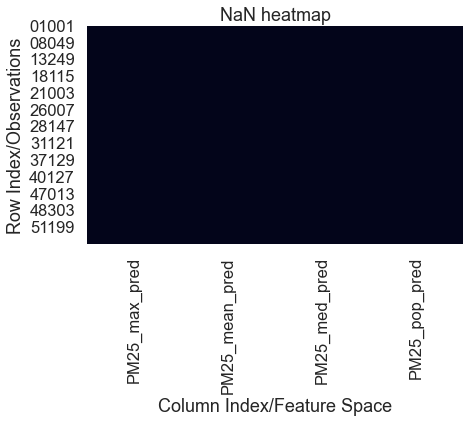

In [117]:
plot_nan_heatmap(yearly_pm25_concentrations_2016)

# Joining the data

In [ ]:
df_pm_emit = 

# Analyse the correlation

Nb: do a correlation heatmap

# Prediction Model